In [15]:
from flask import Flask, jsonify, send_from_directory
from flask_cors import CORS 
import boto3
import pandas as pd
from botocore.exceptions import BotoCoreError, ClientError
import os

import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch
from scipy.signal import find_peaks
import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td
import numpy as np

from sagemaker.tensorflow import TensorFlowPredictor
from sagemaker.sklearn import SKLearnPredictor
import joblib

import time

In [10]:
mainpath = "/Users/soldash/Documents/Tesis/python/Datos/Todas/" #ruta de Carga de los datos
filename = "dataframe_concatenado.csv" #Nombre del archivo a cargar

In [11]:
endpoint_name = 'neuronal-network'
predictor = TensorFlowPredictor(endpoint_name=endpoint_name)

decision_tree_endpoint_name = 'decision-tree-predictor'
decision_tree_predictor = SKLearnPredictor(endpoint_name=decision_tree_endpoint_name)


correct_order = ['RRI', 'SDNN', 'HR', 'HR_std', 'NN50', 'pNN50', 'HF', 'LF', 'Total_power', 'LF_HF']
fbands = {'ulf': (0.0, 0.1), 'vlf': (0.1, 0.2), 'lf': (0.2, 0.3), 'hf': (0.3, 0.4)}

# Inicializa el cliente de SNS
sns = boto3.client('sns')
# ARN de tu tema en SNS
topic_arn = 'arn:aws:sns:us-east-2:027331693661:paciente0'

# Funciones de filtrado
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def notch_filter(data, cutoff, Q, fs):
    nyq = 0.5 * fs
    freq = cutoff / nyq
    b, a = iirnotch(freq, Q)
    y = lfilter(b, a, data)
    return y

#Funciones de procesamiento
def detect_peaks(data, prominence=(300,8000), width=1, distance=50):
    """Detect peaks in the given data."""
    peaks, _ = find_peaks(data, prominence=prominence, width=width, distance=distance)
    return peaks

def compute_RRI(dataframe, peaks):
    """Compute the R-R interval (RRI)."""
    df = dataframe.copy()
    df['RRI'] = 0
    for i in range(len(peaks)):
        if i != 0:
            RRI = df["time"][peaks[i]] - df["time"][peaks[i-1]]
            RRI = RRI.total_seconds() * 1000
            df.loc[peaks[i-1]:peaks[i], ("RRI")] = RRI
    return df, RRI

def compute_SDNN(subset):
    """Compute the SDNN."""
    subset.drop_duplicates(subset="RRI", keep='last', inplace=True)
    return subset.std()["RRI"]

def compute_HR_for_last_30_seconds(sampleDf, peaks):
    """
    Compute the HR for the last 30 seconds of the given DataFrame.

    Parameters:
    - sampleDf (pd.DataFrame): The input DataFrame with 'time' and 'filtered_ECG' columns.
    - peaks (np.array): An array with the indices of the detected peaks.

    Returns:
    - sampleDf (pd.DataFrame): The updated DataFrame with the 'HR' column added.
    """
    
    # Identifica el tiempo de la última muestra
    last_time = sampleDf['time'].iloc[-1]
    sampleDf['HR'] = 0

    # Identifica el tiempo 30 segundos antes de la última muestra
    start_time = last_time - pd.Timedelta(seconds=30)
    subset_indices = sampleDf[sampleDf['time'] >= start_time].index
    start_index = subset_indices[0] if len(subset_indices) > 0 else None

    for index in range(len(sampleDf) - 1, start_index - 1, -1):
        time = sampleDf['time'].iloc[index]
        start_data = time - pd.Timedelta(seconds=60)

        subset_indices = sampleDf[sampleDf['time'] >= start_data].index
        start_index_hr = subset_indices[0] if len(subset_indices) > 0 else None

        if start_index_hr is not None:
            sampleDf.loc[index, "HR"] = len(peaks[(peaks > start_index_hr) & (peaks < index)])

    return sampleDf

def get_neronal_network_prediction(X):
    X_df = pd.DataFrame([X], columns=correct_order) 
    X_scaled = scaler.transform(X_df)
    raw_result = predictor.predict(X_scaled[0].tolist())
    prediction_value = raw_result['predictions'][0][0]
    rounded_result = round(prediction_value)
    return rounded_result

def get_decision_tree_prediction(X):
    result = decision_tree_predictor.predict([X])
    return result[0]

def load_scaler_from_s3(bucket_name, file_name):
    s3 = boto3.client('s3')
    with open(file_name, 'wb') as f:
        s3.download_fileobj(bucket_name, file_name, f)
    scaler = joblib.load(file_name)
    return scaler


app = Flask(__name__)
CORS(app)

bucket_name = 'neuronalnetwork'
file_name = 'scaler_neuronal_net.pkl'
scaler = load_scaler_from_s3(bucket_name, file_name)

client = boto3.client('timestream-query')

In [43]:
data = pd.read_csv(mainpath+filename, sep=",")
df = pd.get_dummies(data, columns=['Seizure'])
df

,ECG,Time,RRI,SDNN,HR,HR_std,NN50,pNN50,HF,LF,Total_power,LF_HF,Seizure_0,Seizure_1,Seizure_2
0,-103.76,2022-07-01 13:25:10.520,664,159.342208,90,1.472363,15,46.875000,1405.554118,1806.423996,7091.854690,1.285204,0,0,1
1,13.07,2022-07-01 13:25:17.080,712,164.505513,90,1.209623,17,50.000000,2767.162779,4630.892866,23767.740430,1.673517,0,0,1
2,-56.95,2022-07-01 13:25:19.080,532,189.341631,91,1.145864,20,54.054054,2944.626153,4952.310225,26649.719756,1.681813,0,0,1
3,83.24,2022-07-01 13:25:16.380,784,164.551134,91,1.242441,17,50.000000,2579.758213,4204.472971,21965.273563,1.629793,0,0,1
4,162.54,2022-07-01 13:25:06.880,682,124.109148,88,1.400575,13,41.935484,572.531005,1497.050280,4298.146616,2.614793,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221795,-20.52,2022-07-02 02:13:48.750,970,451.274655,53,1.346061,12,54.545455,35491.245417,69588.665643,208801.680408,1.960728,1,0,0
221796,22.61,2022-07-02 02:14:16.100,990,251.018848,54,0.627083,11,47.826087,28219.195897,85672.850272,285006.461062,3.035978,1,0,0
221797,-226.50,2022-07-02 02:16:04.100,1525,236.765646,57,0.502655,12,52.173913,9265.808753,12742.977193,74454.898631,1.375269,1,0,0
221798,-35.91,2022-07-02 02:13:52.450,1425,212.634752,54,1.025225,12,54.545455,38532.339011,73043.033828,223054.480452,1.895629,1,0,0


In [44]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def make_prediction(row, tensorflow_predictor, sklearn_predictor, correct_order):
    # Extraer los datos para la predicción
    X_new = row[correct_order].values
    
    # Realizar las predicciones utilizando las funciones proporcionadas
    neural_pred = get_neronal_network_prediction(X_new)
    decision_tree_pred = get_decision_tree_prediction(X_new)
    
    return neural_pred, decision_tree_pred

def add_predictions_to_dataframe_parallel(df, tensorflow_predictor, sklearn_predictor, correct_order):
    # Listas para almacenar las predicciones
    predictions_neuronal = [None] * len(df)
    predictions_decision_tree = [None] * len(df)
    
    # Usar ThreadPoolExecutor para ejecutar las predicciones en paralelo
    with ThreadPoolExecutor(max_workers=60) as executor:
        futures = {executor.submit(make_prediction, df.iloc[index], tensorflow_predictor, sklearn_predictor, correct_order): index for index in range(len(df))}

        for future in as_completed(futures):
            neural_pred, decision_tree_pred = future.result()
            index = futures[future]
            predictions_neuronal[index] = neural_pred
            predictions_decision_tree[index] = decision_tree_pred
            if index % 100 == 0:
                print(index)

    # Añadir las predicciones al DataFrame
    df['prediction_neuronal'] = predictions_neuronal
    df['prediction_decision_tree'] = predictions_decision_tree
    
    return df

# Llamar a la nueva función para obtener el DataFrame con las predicciones añadidas
df_with_predictions = add_predictions_to_dataframe_parallel(df, predictor, decision_tree_predictor, correct_order)
df_with_predictions

6500
6000
400
100
7300
5900
6200
3100
7100
7900
5400
7800
1500
0
4500
9600
2000
8100
5200
6700
500
2200
3900
1900
3700
8000
1800
3600
1000
2400
4100
2600
200
2700
2800
5300
6100
8300
5700
4600
9800
3400
4900
4000
1300
5800
4700
4300
300
5100
9000
7000
4400
4200
1600
9700
6300
2100
1400
4800
9500
5500
2300
7200
8400
3200
900
2500
8800
7600
1700
9300
5000
7500
9200
6800
8500
3800
3300
5600
8600
9100
8700
800
6600
7400
6900
600
9400
8200
6400
3000
8900
2900
3500
1200
700
1100
7700
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14300
14200
14400
14600
14500
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16300
16200
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

,ECG,Time,RRI,SDNN,HR,HR_std,NN50,pNN50,HF,LF,Total_power,LF_HF,Seizure_0,Seizure_1,Seizure_2,prediction_neuronal,prediction_decision_tree
0,-103.76,2022-07-01 13:25:10.520,664,159.342208,90,1.472363,15,46.875000,1405.554118,1806.423996,7091.854690,1.285204,0,0,1,0,0
1,13.07,2022-07-01 13:25:17.080,712,164.505513,90,1.209623,17,50.000000,2767.162779,4630.892866,23767.740430,1.673517,0,0,1,0,0
2,-56.95,2022-07-01 13:25:19.080,532,189.341631,91,1.145864,20,54.054054,2944.626153,4952.310225,26649.719756,1.681813,0,0,1,0,0
3,83.24,2022-07-01 13:25:16.380,784,164.551134,91,1.242441,17,50.000000,2579.758213,4204.472971,21965.273563,1.629793,0,0,1,0,0
4,162.54,2022-07-01 13:25:06.880,682,124.109148,88,1.400575,13,41.935484,572.531005,1497.050280,4298.146616,2.614793,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221795,-20.52,2022-07-02 02:13:48.750,970,451.274655,53,1.346061,12,54.545455,35491.245417,69588.665643,208801.680408,1.960728,1,0,0,1,0
221796,22.61,2022-07-02 02:14:16.100,990,251.018848,54,0.627083,11,47.826087,28219.195897,85672.850272,285006.461062,3.035978,1,0,0,0,0
221797,-226.50,2022-07-02 02:16:04.100,1525,236.765646,57,0.502655,12,52.173913,9265.808753,12742.977193,74454.898631,1.375269,1,0,0,1,0
221798,-35.91,2022-07-02 02:13:52.450,1425,212.634752,54,1.025225,12,54.545455,38532.339011,73043.033828,223054.480452,1.895629,1,0,0,0,0


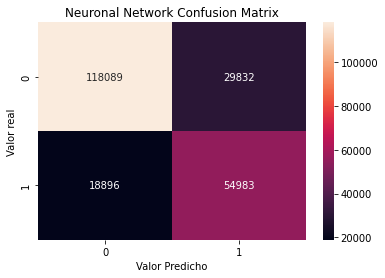

Presición de la red neuronal: 0.65


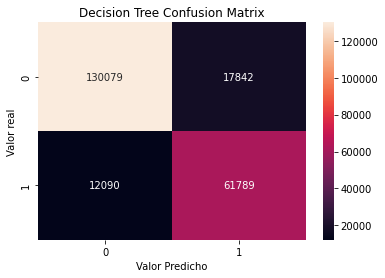

Presición del árbol de decisión: 0.78


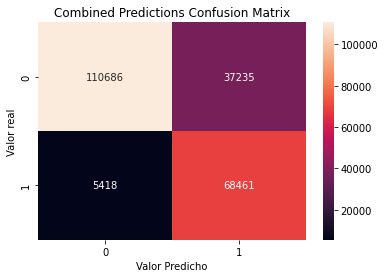

Presición combinada: 0.65


In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns_plot


# Ahora, si tienes una columna de etiquetas verdaderas en tu DataFrame, puedes calcular la matriz de confusión
y_true = df['Seizure_1'].values 
y_pred_neuronal = df_with_predictions['prediction_neuronal'].values
y_pred_decision_tree = df_with_predictions['prediction_decision_tree'].values

# Calcular la matriz de confusión para las predicciones de la red neuronal
cm_neuronal = confusion_matrix(y_true, y_pred_neuronal)

# Calcular la matriz de confusión para las predicciones del árbol de decisión
cm_decision_tree = confusion_matrix(y_true, y_pred_decision_tree)

# Crear un array de predicciones combinadas
# Predicción combinada es 1 solo si ambas predicciones individuales son 1
y_pred_combined = np.logical_or(y_pred_neuronal, y_pred_decision_tree).astype(int)

# Calcular la matriz de confusión para las predicciones combinadas
cm_combined = confusion_matrix(y_true, y_pred_combined)

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, title):
    sns_plot.heatmap(cm, annot=True, fmt='d')
    plt.title(title)
    plt.xlabel('Valor Predicho')
    plt.ylabel('Valor real')
    plt.show()
    
# Función para calcular la precisión a partir de la matriz de confusión
def calculate_precision(cm):
    # Verdaderos positivos son cm[0, 0] y falsos positivos son cm[0, 1]
    TP = cm[1, 1]
    FP = cm[0, 1]
    precision = TP / float(TP + FP)
    return precision

# Visualizar la matriz de confusión para la red neuronal
plot_confusion_matrix(cm_neuronal, "Neuronal Network Confusion Matrix")

# Calcular la precisión para la red neuronal
precision_neuronal = calculate_precision(cm_neuronal)
print(f"Presición de la red neuronal: {precision_neuronal:.2f}")

# Visualizar la matriz de confusión para el árbol de decisión
plot_confusion_matrix(cm_decision_tree, "Decision Tree Confusion Matrix")

# Calcular la precisión para el árbol de decisión
precision_decision_tree = calculate_precision(cm_decision_tree)
print(f"Presición del árbol de decisión: {precision_decision_tree:.2f}")

# Visualizar la matriz de confusión para las predicciones combinadas
plot_confusion_matrix(cm_combined, "Combined Predictions Confusion Matrix")

# Calcular la precisión para las predicciones combinadas
precision_combined = calculate_precision(cm_combined)
print(f"Presición combinada: {precision_combined:.2f}")
